In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'sample_submission.csv', 'test']


In [17]:
from tensorflow.keras.applications import InceptionResNetV2
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [18]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

In [19]:
import re
from random import shuffle
from glob import glob

train_files = glob('../input/train/*.jpg')
test_files = glob('../input/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

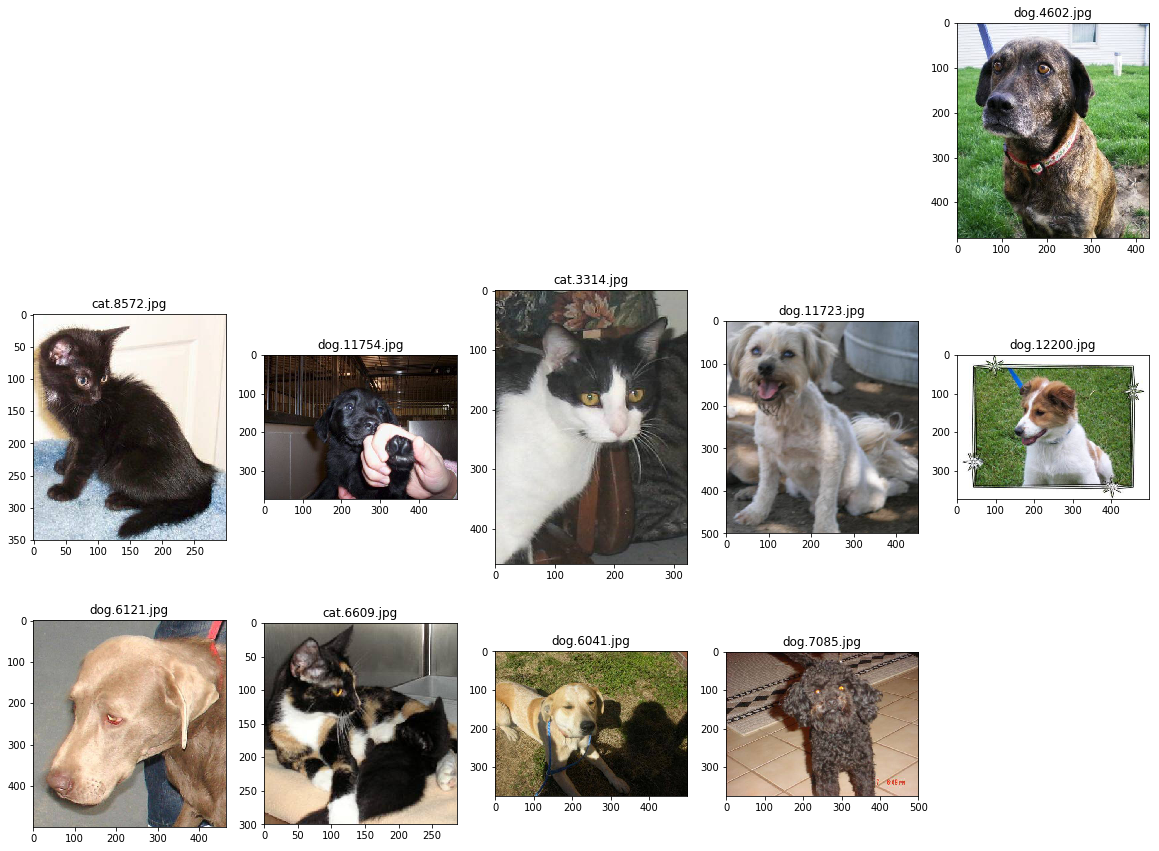

In [20]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

In [21]:
# base_model -  объект класса keras.models.Model (Functional Model)
# будем использовать модель ResNet50
base_model = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [22]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [23]:
# добавим 3 полносвязных слоя с BatchNormalization
x = base_model.layers[-5].output
x = keras.layers.Flatten()(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation='relu', name='dense_one')(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation='relu', name='dense_two')(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation='relu', name='dense_three')(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=keras.regularizers.l1(1e-4), name='output')(x)

model = Model(inputs=base_model.input, outputs=x)

In [24]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [25]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=150,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/150
10/10 [==============================] - 6s 637ms/step - loss: 0.2947 - acc: 0.8844 - val_loss: 0.5008 - val_acc: 0.6900
Epoch 2/150
10/10 [==============================] - 1s 109ms/step - loss: 0.2273 - acc: 0.9031 - val_loss: 0.2674 - val_acc: 0.8900
Epoch 3/150
10/10 [==============================] - 1s 110ms/step - loss: 0.1943 - acc: 0.9312 - val_loss: 0.2618 - val_acc: 0.8900
Epoch 4/150
10/10 [==============================] - 2s 165ms/step - loss: 0.1776 - acc: 0.9406 - val_loss: 0.2071 - val_acc: 0.9300
Epoch 5/150
10/10 [==============================] - 2s 162ms/step - loss: 0.1718 - acc: 0.9250 - val_loss: 0.1884 - val_acc: 0.9500
Epoch 6/150
10/10 [==============================] - 2s 164ms/step - loss: 0.1771 - acc: 0.9312 - val_loss: 0.1606 - val_acc: 0.9400
Epoch 7/150
10/10 [==============================] - 2s 163ms/step - loss: 0.1386 - acc: 0.9469 - val_loss: 0.0914 - val_acc: 0.9900
Epoch 8/150
10/10 [==============================] - 2s 160ms/step - 

10/10 [==============================] - 2s 161ms/step - loss: 0.0465 - acc: 0.9812 - val_loss: 0.0391 - val_acc: 0.9800
Epoch 124/150
10/10 [==============================] - 2s 168ms/step - loss: 0.0587 - acc: 0.9781 - val_loss: 0.0390 - val_acc: 0.9800
Epoch 125/150
10/10 [==============================] - 2s 167ms/step - loss: 0.0626 - acc: 0.9719 - val_loss: 0.0427 - val_acc: 0.9800
Epoch 126/150
10/10 [==============================] - 2s 160ms/step - loss: 0.0928 - acc: 0.9688 - val_loss: 0.0353 - val_acc: 0.9800
Epoch 127/150
10/10 [==============================] - 2s 166ms/step - loss: 0.0521 - acc: 0.9781 - val_loss: 0.0286 - val_acc: 0.9800
Epoch 128/150
10/10 [==============================] - 2s 160ms/step - loss: 0.0476 - acc: 0.9812 - val_loss: 0.0304 - val_acc: 0.9800
Epoch 129/150
10/10 [==============================] - 2s 159ms/step - loss: 0.1037 - acc: 0.9594 - val_loss: 0.0300 - val_acc: 0.9900
Epoch 130/150
10/10 [==============================] - 2s 163ms/step 

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [27]:
model.save('cats-dogs-vgg16.hdf5')

In [28]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

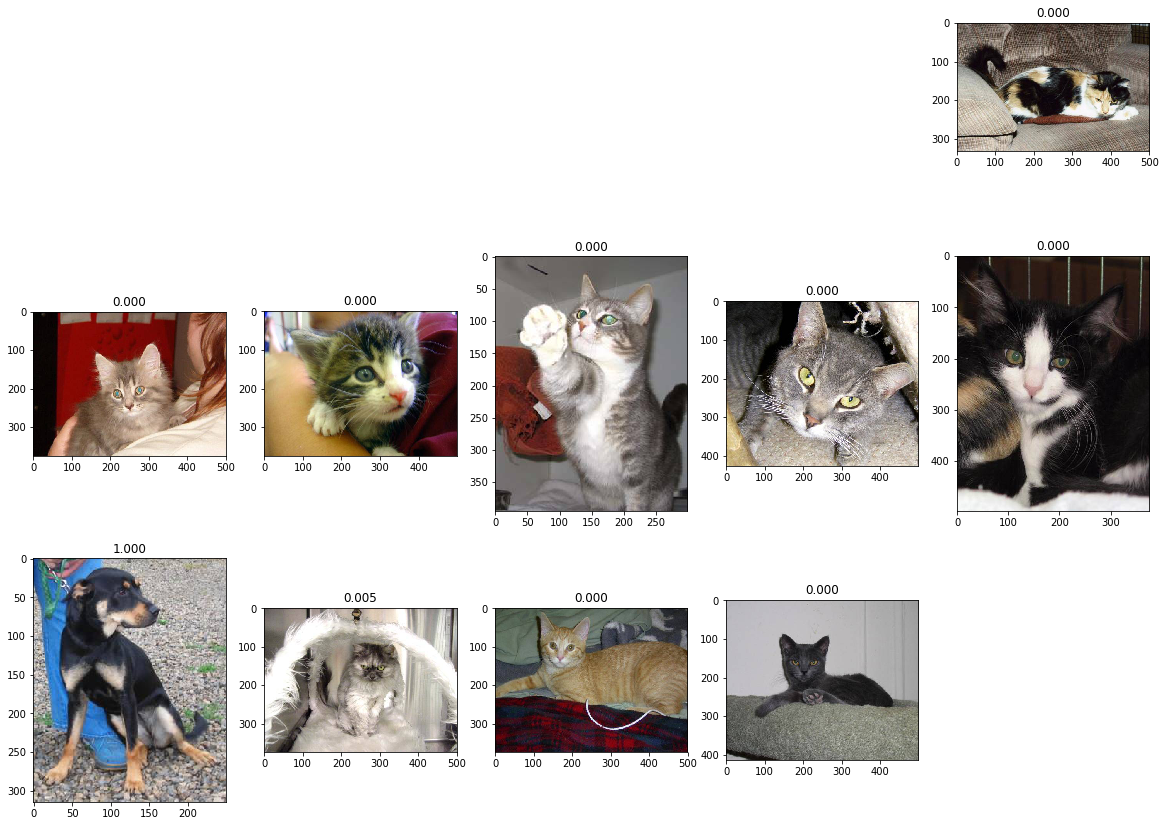

In [29]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[100:][:10], pred[100:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

In [30]:
with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

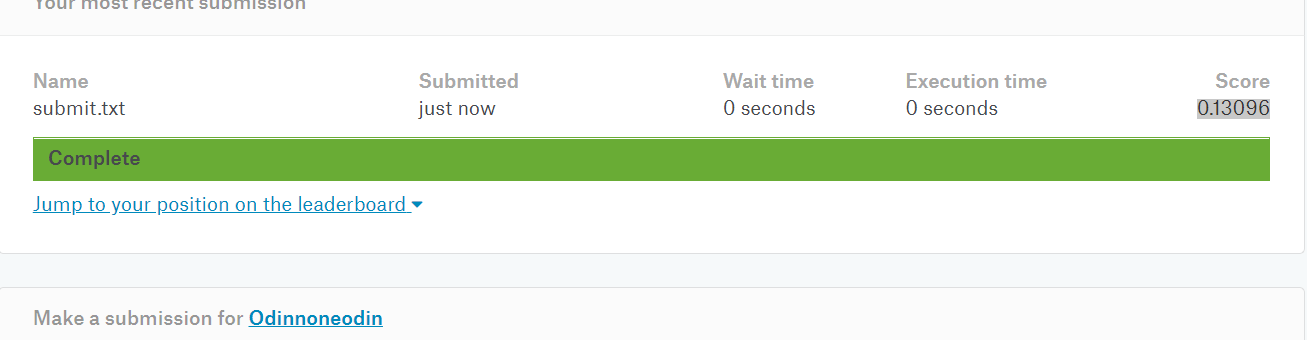

# LogLoss 0.13096